In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
nodes = gpd.read_file("data/graph/nodes.shp")
edges = gpd.read_file("data/graph/edges.shp")

In [3]:
categories = ["education", "bank", "healthcare", "transportation", "food" ]

#initialize all entries to False
for category in categories:
    nodes[category] = False

#if the node is a POI then set its entries to True
"""for index, node in nodes.iterrows():
    if node["POI"] in categories:
        for category in categories:
            nodes.at[index, category] = True"""

'for index, node in nodes.iterrows():\n    if node["POI"] in categories:\n        for category in categories:\n            nodes.at[index, category] = True'

In [4]:
nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

G = ox.utils_graph.graph_from_gdfs(nodes, edges)

<h1>Coverage</h1>
<p>Given a graph G = (nodes, edges) knowing that in the edges there are some POIs, modify the nodes table to have that: nodes below 15 minutes to at least a POI of a certain category have that category column set to true.</p>
<p>Example: Suppose node i is below 15 minutes to 2 schools, 4 supermarkets and nothing more, then these will be its column values</p>
<table>
  <tr>
    <th>education</th>    
    <th>bank</th>
    <th>healthcare</th>
    <th>transportation</th>    
    <th>food</th>
  </tr>
  <tr>
    <td>True</td>
    <td>False</td>
    <td>False</td>
    <td>False</td>
    <td>True</td>
  </tr>

In [5]:
travel_speed = 5  # walking speed in km/hour

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [6]:
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

osmid                     highway  oneway  \
u v   key                                                              
0 235 0                244968982                        path       0   
      1                 41224006                    tertiary       0   
      2    [23516585, 960693916]  ['footway', 'residential']       0   
      3                244969034                        path       0   
  233 0                244969016                        path       0   

                reversed      length  from   to width  u_original  v_original  \
u v   key                                                                       
0 235 0            False  262.005714     0  235     3   254672751  1706766353   
      1            False  205.686533     0  235   NaN   254672878  2796391751   
      2    [False, True]  269.826579     0  235   NaN  2522360919  2522409502   
      3             True  219.053507     0  235     3  2522360919  2522360929   
  233 0            False  269.193872     0  233   2.5   243488899  2522360913   

                                                    geometry      time lanes  \
u v   key                                                                      
0 235 0    LINESTRING (724701.900 5034203.206, 724666.149...  3.144069   NaN   
      1    LINESTRING (724701.900 5034203.206, 724674.181...  2.468238     2   
      2    LINESTRING (724701.900 5034203.206, 724686.435...  3.237919   NaN   
      3    LINESTRING (724701.900 5034203.206, 724678.669...  2.628642   NaN   
  233 0    LINESTRING (724714.668 5034196.773, 724771.919...  3.230326   NaN   

                              name maxspeed tunnel bridge access est_width  \
u v   key                                                                    
0 235 0                        NaN      NaN    NaN    NaN    NaN       NaN   
      1    Via Annibale da Bassano      NaN    NaN    NaN    NaN       NaN   
      2    Via Annibale da Bassano      NaN    NaN    NaN    NaN       NaN   
      3                        NaN      NaN    NaN    NaN    NaN       NaN   
  233 0                        NaN      NaN    NaN    NaN    NaN       NaN   

          service area  ref junction  
u v   key                             
0 235 0       NaN  NaN  NaN      NaN  
      1       NaN  NaN  NaN      NaN  
      2       NaN  NaN  NaN      NaN  
      3       NaN  NaN  NaN      NaN  
  233 0       NaN  NaN  NaN      NaN

In [7]:
#edges = ox.graph_to_gdfs(G, nodes=False)

#G = ox.graph_from_gdfs(nodes, edges)

<h2>Plot graph with all POIs</h2>
<p>We will plot a graph with red nodes representing normal nodes and blue nodes representing POIs</p>

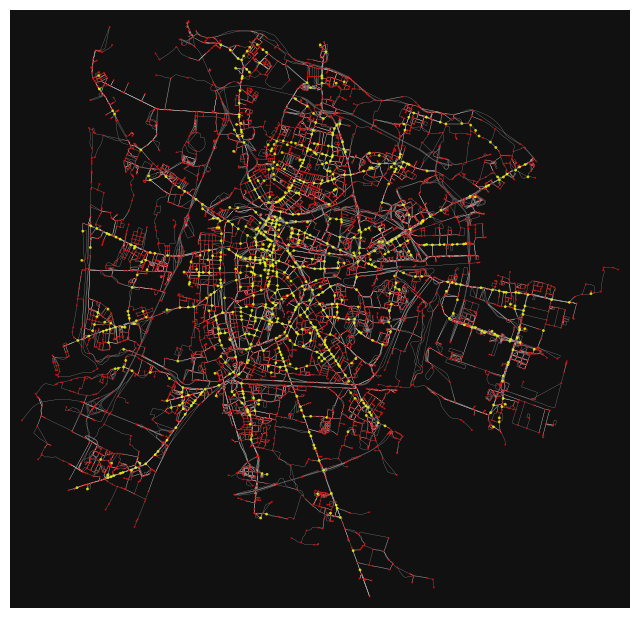

In [8]:
## color the nodes: red - normal; yellow - POIs
node_colors = {}
node_sizes = {}
for node, data in G.nodes(data=True):
    node_id = node
    poi = data.get("POI", None)
    if poi in categories:
        node_colors[node_id] = "yellow"
        node_sizes[node_id] = 4
    else:
        node_colors[node_id] = "red"
        node_sizes[node_id] = 1.8
        
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

<h2>Plot subgraphs with close nodes for each category</h2>
<p>Plot multiple graphs (one for each category) where blue nodes are POIs, green nodes are the ones near to at least a POI, i.e. covered, red are uncovered nodes (>15 min).</p>

In [9]:
#Create a list of POIs for each category
poi_nodes = {}
for category in categories:
    poi_nodes[category] = []
for node, data in G.nodes(data=True):
    node_id = node
    poi = data.get("POI", None)
    if poi in categories:
        poi_nodes[poi].append(node_id)

In [10]:
#Compute a subgraph of covered nodes for each category
trip_time = 15
subgraph_nodes = {}
for category in categories:
    subgraph_nodes[category] = []
    for poi_id in poi_nodes[category]:
        subgraph = nx.ego_graph(G, poi_id, radius=trip_time, distance="time", undirected=True)
        for n in subgraph.nodes():
            subgraph_nodes[category].append(n)

for c in categories:
    print(len(subgraph_nodes[c])) #subgraph_nodes contains duplicate nodes (that's why nombers are high)


6608
3830
5319
31389
9139


In [19]:
#Update nodes table with coverage results
for index, node in nodes.iterrows():
    for category in categories:
        if(index in subgraph_nodes[category]):
            nodes.at[index, category] = True

<h3>Print graph with covered nodes for each category</h3>

In [12]:
def printCoveredNodes(poi_cat, print_=True):
    node_colors = []
    covered_cnt = 0
    poi_cnt = 0
    uncovered_cnt = 0
    for index, node in nodes.iterrows():
        if (nodes.at[index, "POI"] == poi_cat):
            node_colors.append("yellow")  
            poi_cnt += 1
        else:
            if nodes.at[index, poi_cat] == True:
                node_colors.append("green")  
                covered_cnt += 1
            else:
                node_colors.append("red")
                uncovered_cnt += 1
    if(print_):
        print("Number of covered nodes (green): ", covered_cnt)
        print("Number of poi nodes (yellow): ", poi_cnt)
        fig, ax = ox.plot_graph(
            G,
            node_color=node_colors,
            node_size=4,
            node_alpha=0.8,
            edge_linewidth=0.2,
            edge_color="#999999",
        )
    return covered_cnt

Printing graph of covered nodes from  education
Number of covered nodes (green):  3076
Number of poi nodes (yellow):  91


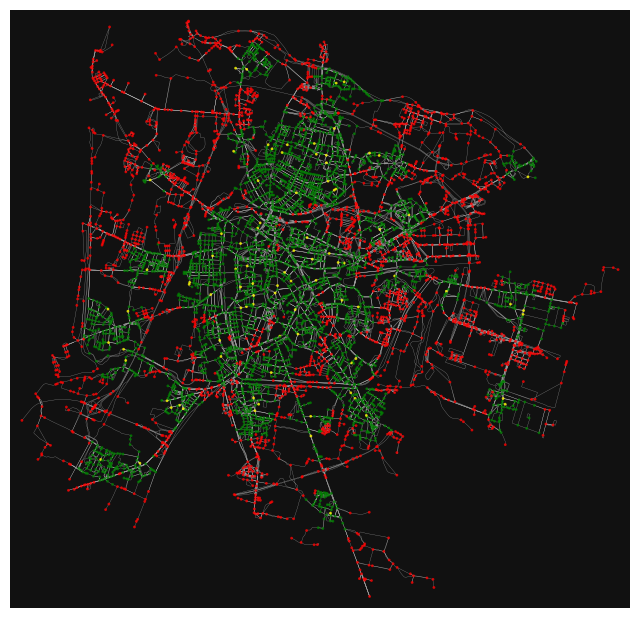

Printing graph of covered nodes from  bank
Number of covered nodes (green):  1716
Number of poi nodes (yellow):  43


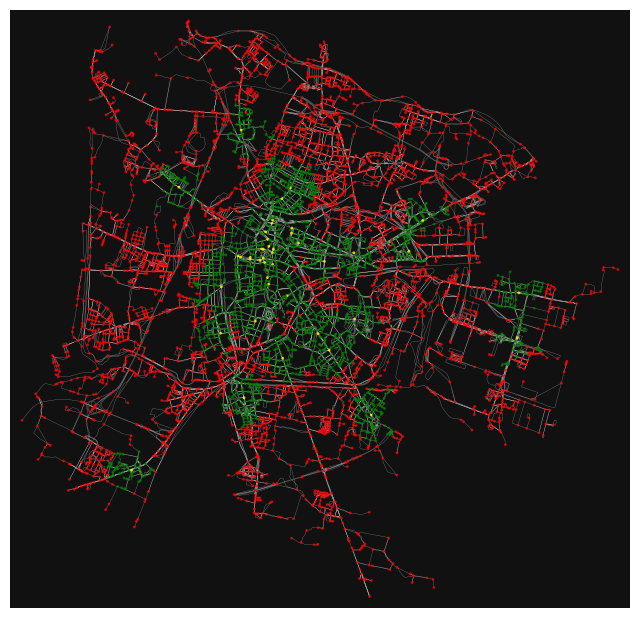

Printing graph of covered nodes from  healthcare
Number of covered nodes (green):  2501
Number of poi nodes (yellow):  64


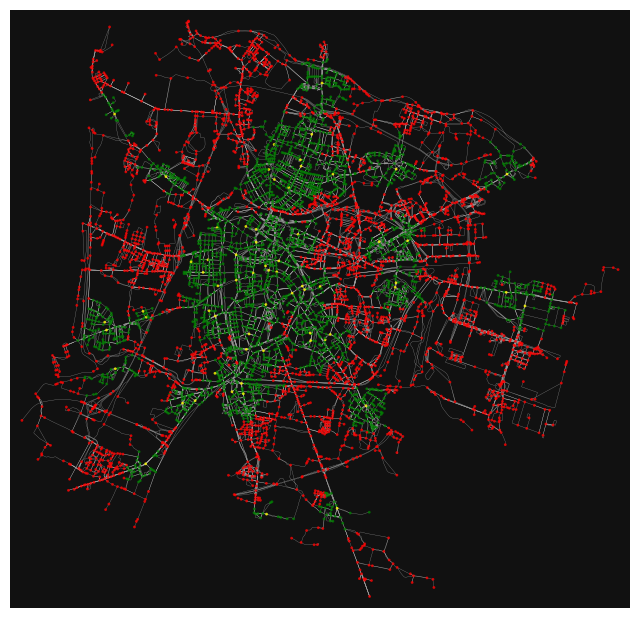

Printing graph of covered nodes from  transportation
Number of covered nodes (green):  4293
Number of poi nodes (yellow):  452


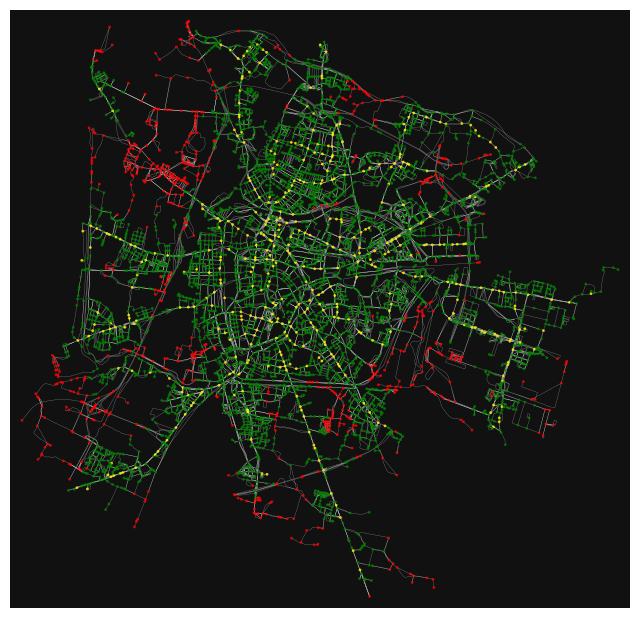

Printing graph of covered nodes from  food
Number of covered nodes (green):  3549
Number of poi nodes (yellow):  120


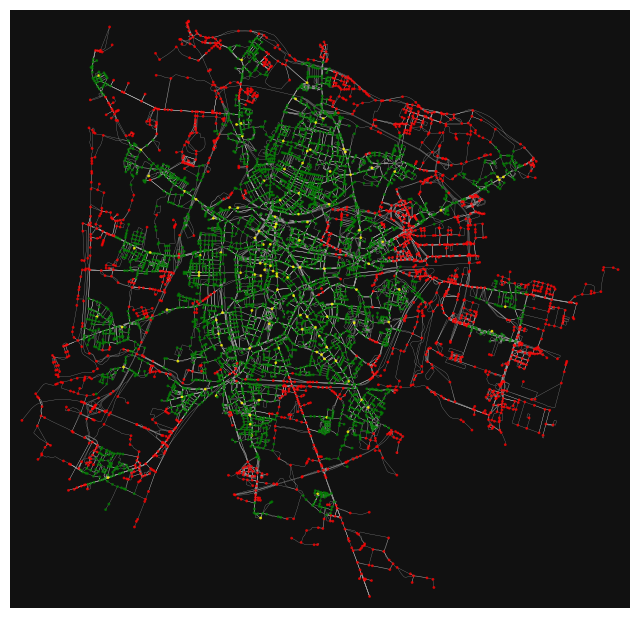

In [13]:
for c in categories:
    print("Printing graph of covered nodes from " , c)
    printCoveredNodes(c)

In [20]:
G_upd = ox.utils_graph.graph_from_gdfs(nodes, edges)
ox.save_graph_shapefile(G_upd, filepath="data/ego", encoding="utf-8")

<h1>Analysis</h1>
<p>Now that we have obtained all covered nodes for each category we can evaluate some interesting results.</p>

In [14]:
from IPython.display import Markdown as md

In [15]:
s = "<h2>Covered nodes for each category</h2>"
if(len(categories) > 0):
    s +="<table>"
    s +="<tr>"
    s +="<th>Category</th>"
    s +="<th>Num. Covered nodes</th>"
    s +="<th>Percentage of coverage</th>"
    s +="</tr>"
    for c in categories:
        s +="<tr>"
        covered = printCoveredNodes(c, False)
        percentage = covered * 100 / len(nodes)
        formatted_percentage = round(percentage, 2)
        result_str = str(formatted_percentage)
        s +="<td>"+c+"</td>" 
        s +="<td>"+str(covered)+"</td>" 
        s +="<td>"+result_str+"%</td>" 
        s +="</tr>"
        #print(c, ": " , covered, " covered nodes: %.1f" %(covered*100/len(nodes)), "% of the total"
    s +="</table>"
s += """
<h2>Percentage of nodes covered by all categories</h2>
<p>The following number is a possible representation of how a city is well covered:</p>
"""
# Save nodes'id that are near all POIs
near_all_nodes = []
for index, node in nodes.iterrows():
    near_all = True
    for category in categories:
        if(index not in subgraph_nodes[category]):
            near_all = False
    if(near_all):
        near_all_nodes.append(index)
s +="<table>"
s +="<tr>"
s +="<th>Number of covered nodes</th>"
s +="<th>Total number of nodes</th>"
s +="<th>Percentage of covered nodes</th>"
s +="</tr>"
s +="<tr>"
percentage = len(near_all_nodes) * 100 / len(nodes)
formatted_percentage = round(percentage, 2)
result_str = str(formatted_percentage)
s +="<td>"+str(len(near_all_nodes))+"</td>" 
s +="<td>"+str(len(nodes))+"</td>" 
s +="<td>"+result_str+"%</td>" 
s +="</tr>"
s +="</table>"
s += """
<h2>Percentage of isolated nodes</h2>
<p>These are the nodes that are not near any POI:</p>

"""
# Save nodes'id that are not near any POI
isolated_nodes = []
for index, node in nodes.iterrows():
    isolated = True
    for category in categories:
        if(index in subgraph_nodes[category]):
            isolated = False
    if(isolated):
        isolated_nodes.append(index)
s +="<table>"
s +="<tr>"
s +="<th>Number of isolated nodes</th>"
s +="<th>Total number of nodes</th>"
s +="<th>Percentage of isolated nodes</th>"
s +="</tr>"
s +="<tr>"
percentage = len(isolated_nodes) * 100 / len(nodes)
formatted_percentage = round(percentage, 2)
result_str = str(formatted_percentage)
s +="<td>"+str(len(isolated_nodes))+"</td>" 
s +="<td>"+str(len(nodes))+"</td>" 
s +="<td>"+result_str+"%</td>" 
s +="</tr>"
s +="</table>"
md(s)

<h2>Covered nodes for each category</h2><table><tr><th>Category</th><th>Num. Covered nodes</th><th>Percentage of coverage</th></tr><tr><td>education</td><td>3076</td><td>56.32%</td></tr><tr><td>bank</td><td>1716</td><td>31.42%</td></tr><tr><td>healthcare</td><td>2501</td><td>45.79%</td></tr><tr><td>transportation</td><td>4293</td><td>78.6%</td></tr><tr><td>food</td><td>3549</td><td>64.98%</td></tr></table>
<h2>Percentage of nodes covered by all categories</h2>
<p>The following number is a possible representation of how a city is well covered:</p>
<table><tr><th>Number of covered nodes</th><th>Total number of nodes</th><th>Percentage of covered nodes</th></tr><tr><td>1014</td><td>5462</td><td>18.56%</td></tr></table>
<h2>Percentage of isolated nodes</h2>
<p>These are the nodes that are not near any POI:</p>

<table><tr><th>Number of isolated nodes</th><th>Total number of nodes</th><th>Percentage of isolated nodes</th></tr><tr><td>440</td><td>5462</td><td>8.06%</td></tr></table>

<h2>Graph plot of nodes covered by all categories and of isolated nodes</h2>

Graph of 15 minutes nodes:
	- yellow: POIs
	- green: Nodes near all categories
	- red: Isolated nodes
	- grey: Other nodes


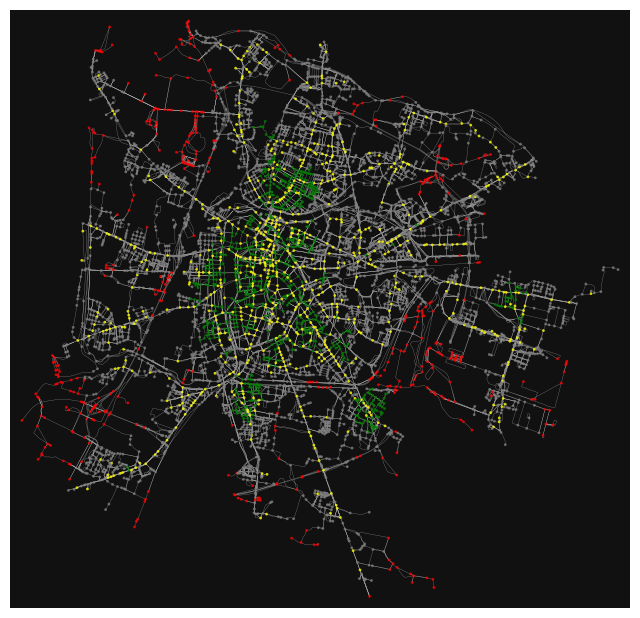

In [16]:
node_colors = []
covered_cnt = 0
poi_cnt = 0
uncovered_cnt = 0
for index, node in nodes.iterrows():
    if (nodes.at[index, "POI"] in categories):
        node_colors.append("yellow")  
    else:
        if (index in near_all_nodes):
            node_colors.append("green")  
        elif(index in isolated_nodes):
            node_colors.append("red")
        else:
            node_colors.append("grey")
print("Graph of 15 minutes nodes:\n\t- yellow: POIs\n\t- green: Nodes near all categories\n\t- red: Isolated nodes\n\t- grey: Other nodes")
fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=4,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)